# MNIST FNN Neural Network

In this notebook, we will:

1. **Load** the MNIST dataset  
2. **Preprocess** (normalize, reshape, one-hot encode, shuffle & split)  
3. **Train** with mini-batch SGD  
4. **Visualize** a few test predictions  


In [15]:
import sys, numpy as np, matplotlib.pyplot as plt, pandas as pd
from pathlib import Path
from src.layers import Dense                   
from sklearn.datasets import fetch_openml
from src.utils  import (                       
    softmax,               
    cross_entropy_loss,    
    softmax_ce_gradient    
)

project_root = Path.cwd().parent          
sys.path.append(str(project_root))


In [ ]:
def load_preprocess_mnist():
    mnist = fetch_openml('mnist_784', version=1)
    X_raw = mnist.data.to_numpy().astype(np.float32)   # (70000, 784)
    y_raw = mnist.target.to_numpy().astype(int)        # (70000,)

    # Normalize to [0,1]
    X_norm = X_raw / 255.0

    # One-hot encode labels into (70000, 10)
    num_classes = 10
    I = np.eye(num_classes)
    Y_onehot = I[y_raw]                                # (70000, 10)

    # Shuffle entire dataset
    n_total = X_norm.shape[0]
    perm = np.random.permutation(n_total)
    X_shuf = X_norm[perm]      # (70000, 784)
    Y_shuf = Y_onehot[perm]    # (70000, 10)

    # Split: 60k train+val, 10k test
    n_train_val = 60000
    X_train_val = X_shuf[:n_train_val]  # (60000, 784)
    Y_train_val = Y_shuf[:n_train_val]  # (60000, 10)
    X_test = X_shuf[n_train_val:]       # (10000, 784)
    Y_test = Y_shuf[n_train_val:]       # (10000, 10)

    # Further split train_val into 5k val, 55k train
    n_val = 5000
    X_val = X_train_val[:n_val]         # (5000, 784)
    Y_val = Y_train_val[:n_val]         # (5000, 10)
    X_train = X_train_val[n_val:]       # (55000, 784)
    Y_train = Y_train_val[n_val:]       # (55000, 10)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [9]:
def visualize_samples(layer1: Dense, layer2: Dense, X_test: np.ndarray, Y_test: np.ndarray, n_samples=8):
    """
    Picks n_samples at random from X_test/Y_test, runs them through the network,
    and plots the images side by side with True vs. Predicted labels.
    """
    import matplotlib.pyplot as plt

    idxs = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
    X_sel = X_test[idxs]          # (n_samples, input_dim)
    Y_sel = Y_test[idxs]          # (n_samples, n_classes)

    z1 = layer1.forward(X_sel)    # (n_samples, hidden_dim)
    z2 = layer2.forward(z1)       # (n_samples, n_classes)
    probs = softmax(z2)           # (n_samples, n_classes)
    preds = np.argmax(probs, axis=1)
    true_labels = np.argmax(Y_sel, axis=1)

    plt.figure(figsize=(n_samples * 1.2, 2))
    for i in range(n_samples):
        img = X_sel[i].reshape(28, 28)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"T:{true_labels[i]}\nP:{preds[i]}")
    plt.show()

Epoch 1/10  —  train_loss: 0.3459  —  val_loss: 0.3495  —  val_acc: 0.8970
Epoch 2/10  —  train_loss: 0.2752  —  val_loss: 0.2834  —  val_acc: 0.9172
Epoch 3/10  —  train_loss: 0.2409  —  val_loss: 0.2454  —  val_acc: 0.9278
Epoch 4/10  —  train_loss: 0.2108  —  val_loss: 0.2204  —  val_acc: 0.9376
Epoch 5/10  —  train_loss: 0.1874  —  val_loss: 0.1963  —  val_acc: 0.9474
Epoch 6/10  —  train_loss: 0.1683  —  val_loss: 0.1805  —  val_acc: 0.9506
Epoch 7/10  —  train_loss: 0.1524  —  val_loss: 0.1642  —  val_acc: 0.9552
Epoch 8/10  —  train_loss: 0.1432  —  val_loss: 0.1594  —  val_acc: 0.9566
Epoch 9/10  —  train_loss: 0.1269  —  val_loss: 0.1460  —  val_acc: 0.9586
Epoch 10/10  —  train_loss: 0.1202  —  val_loss: 0.1414  —  val_acc: 0.9610
Test acc: 0.9585


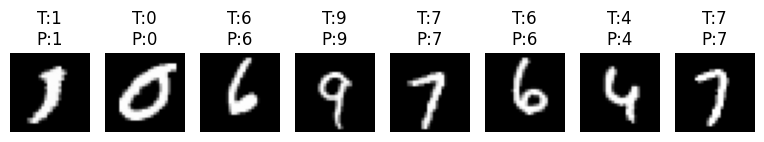

In [ ]:
from src.layers import Dense
from src.nn     import train_two_layer, evaluate_two_layer

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_preprocess_mnist()

layer1 = Dense(784, 64, 'relu')
layer2 = Dense(64, 10,  'linear')

history = train_two_layer(layer1, layer2,
                          X_train, Y_train,
                          X_val,   Y_val,
                          num_epochs=10,
                          learning_rate=0.1,
                          batch_size=128)

print("Test acc:", evaluate_two_layer(layer1, layer2, X_test, Y_test))
visualize_samples(layer1, layer2, X_test, Y_test, n_samples=8)


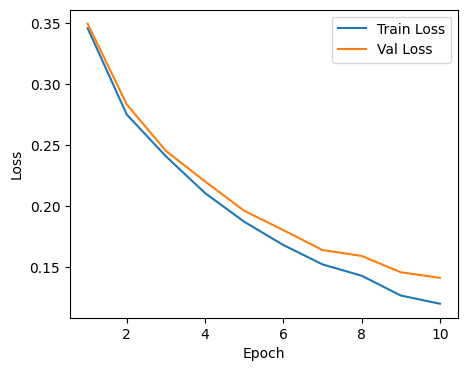

In [11]:
import matplotlib.pyplot as plt

epochs = len(history['train_loss'])
plt.figure(figsize=(5,4))
plt.plot(range(1, epochs+1), history['train_loss'], label='Train Loss')
plt.plot(range(1, epochs+1), history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()

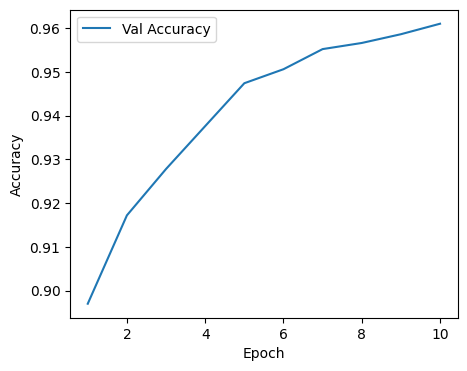

In [12]:
plt.figure(figsize=(5,4))
plt.plot(range(1, epochs+1), history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.show()
